In [1]:
# Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
style.use('fivethirtyeight')

In [2]:
# Functions

# A function for setting up normalized, standardized, and variance thresholded data
def StandShuffle(df, outcome):
    '''
    df - A dataframe consisting of only numeric features and an outcome feature
    outcome - the name of the outcome feature as a string
    dfNew - The standard scaled and shuffled dataframe
    '''
    
    # Shuffle the Data
    shuffled_df = df.sample(frac=1,random_state=4)
    
    # Split the data by training or testing
    X = shuffled_df.drop([outcome], axis = 1).values
    y = shuffled_df[outcome].values
    
    # Standardizing all values
    scaler = StandardScaler()
    
    # Fit the scaler to the training data
    scaler.fit(X)
    
    # Apply to the training data
    X = scaler.transform(X)
    
    dfNew = pd.DataFrame(X, columns = df.drop([outcome], axis = 1).columns)
    dfNew[outcome] = y
                         
    return dfNew

# General Grid Search Class
def GridSearch(grid, model, x_train, y_train):
    model_cv = GridSearchCV(model, grid, cv = 10)
    
    model_cv.fit(x_train, y_train)
    
    bestParams = model_cv.best_params_
    
    return bestParams


def RandFor(df, outcome):
    
    '''
    Returns a grid searched XGBoost classifier
    df - A dataframe consisting of only numeric features and an outcome feature
    outcome - the name of the outcome feature as a string
    '''
    
    X = df.drop([outcome], axis = 1).values
    y = df[outcome]
    
    rf = XGBClassifier()
    
    x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, )
    
    grid = {"eta":np.arange(0,1.05,0.1), "max_depth":np.arange(3,10,1)}
    
    bestParams = GridSearch(grid, rf, x_train_rf, y_train_rf)
    
    rf = XGBClassifier(eta = bestParams["eta"], max_depth = bestParams["max_depth"])
    
    rf.fit(x_train_rf, y_train_rf)
    return rf, x_train_rf, x_test_rf, y_train_rf, y_test_rf

def LearningCurves(estimator, X, y):
    cv = ShuffleSplit(test_size=0.2, random_state=0)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes = np.linspace(0.1, 0.7, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    
    plt.xlabel("Training Set Size")
    plt.ylabel("Score (R^2)")
    plt.legend(loc="best")
    plt.grid()

In [3]:
# Importing the data
df = pd.read_csv("../../Data/PlaylistData/COmbinedPlaylists.csv", encoding = "cp1252")
df.head()

,Song,Artist,Release,BPM,Energy,Dance,Loud,Valence,Length,Acoustic,Popularity,Rnd,Playlist
0,Blood // Water,grandson,6/15/2018,154.0,89.0,50.0,-6.0,63.0,215.0,0.0,72.0,1736,Catharsis
1,thoughts & prayers,grandson,3/23/2018,150.0,93.0,49.0,-3.0,33.0,225.0,0.0,61.0,4109,Catharsis
2,Stick Up,grandson,6/15/2018,136.0,93.0,31.0,-5.0,30.0,223.0,0.0,61.0,9971,Catharsis
3,Overdose,grandson,6/15/2018,144.0,69.0,53.0,-6.0,12.0,231.0,0.0,59.0,111,Catharsis
4,6:00,grandson,6/15/2018,96.0,81.0,29.0,-6.0,35.0,266.0,0.0,58.0,7924,Catharsis


# Choosing Playlists
Based on `Update1`, it appears that Catharsis and Nostalgia are very different playlists. These playlists will be compared.

In [4]:
# Creating the dataset
dfCaNo = df.loc[(df["Playlist"] == "Catharsis") | (df["Playlist"] == "Nostalgia")]

In [5]:
# Checking if any songs exist in both playlists
dfCaNo[dfCaNo.duplicated(subset = dfCaNo.columns[:-1])]

,Song,Artist,Release,BPM,Energy,Dance,Loud,Valence,Length,Acoustic,Popularity,Rnd,Playlist


There is no overlap between these playlists, perfect!

# Cleaning & Preprocessing
We'll prepare the data here so that it can be analyzed and passed into a ML model

## Extract Attributes
We only want to work with the attributes BPM, Energy, Dance, Loud, Valence, Length, Acoustic, and Popularity

In [6]:
# Removing extraneous features
dfCaNo = dfCaNo[["BPM", "Energy", "Dance", "Loud", "Valence", "Length", "Acoustic", "Popularity", "Playlist"]]

## Binarizing Outcome Variable
The playlists need to be converted to a numeric variable for modeling. In this case, "Catharsis" will be 1 and "Nostalgia" will be 0.

In [7]:
# Binarizing outcome
dfCaNo["Playlist"] = np.where(dfCaNo["Playlist"] == "Catharsis", 1, 0)

# Saving playlist names for later use
playlistNames = ["Nostalgia", "Catharsis"]

## Standardizing
The values of each feature need to be standardized about the same mean. The following code will make the new mean of each feature 0, and the values should vary by z-scores about zero now.

The values have also been shuffled so that there is no longer and ordering by playlist.

In [8]:
dfCaNo = StandShuffle(dfCaNo, "Playlist")

## Sampling
It appears that the dataset has slightly more "Catharsis" songs than "Nostalgia" songs. Downsampling will be used to try and ensure that the model is not trained on a biased dataset.

In [9]:
# Number of Catharsis and Nostalgia Songs
print("Number of Catharsis Songs: " + str(len(dfCaNo.loc[dfCaNo["Playlist"] == 1])))
print("Number of Nostalgia Songs: " + str(len(dfCaNo.loc[dfCaNo["Playlist"] == 0])))

# Percent of Catharsis and Nostalgia songs
print("Percent Catharsis Songs: " + str(round(len(dfCaNo.loc[dfCaNo["Playlist"] == 1])/len(dfCaNo), 3)*100) + "%")
print("Percent Nostalgia Songs: " + str(round(len(dfCaNo.loc[dfCaNo["Playlist"] == 0])/len(dfCaNo), 3)*100) + "%")

Number of Catharsis Songs: 124
Number of Nostalgia Songs: 71
Percent Catharsis Songs: 63.6%
Percent Nostalgia Songs: 36.4%


In [10]:
# Percent of Nostalgia songs versus Catharsis songs
perNos = len(dfCaNo.loc[dfCaNo["Playlist"] == 0])/len(dfCaNo.loc[dfCaNo["Playlist"] == 1])
print("Percent of Nostalgia/Catharsis Songs: " + str(round(perNos,3)*100))

Percent of Nostalgia/Catharsis Songs: 57.3


In [11]:
# Removing a random set of Catharsis songs so that there are an equal number of
# Catharsis and Nostalgia songs remaining
dfCathDownsampled = dfCaNo.loc[dfCaNo["Playlist"] == 1].sample(frac=perNos,random_state=4)
print("Number of Catharsis songs after downsampling: " + str(len(dfCathDownsampled)))

Number of Catharsis songs after downsampling: 71


Perfect! Now we have the same number of each kind of song. Time to recombine into a single dataset.

In [12]:
dfCaNo = dfCaNo.loc[dfCaNo["Playlist"] == 0].append(dfCathDownsampled)
print("Number of songs after downsampling: " + str(len(dfCaNo)))

Number of songs after downsampling: 142


# Exploration
We'll see if any features arise as important upon a first pass. The code included in this section is modified from `Update1/Scratch_Work.ipynb`.

## BPM

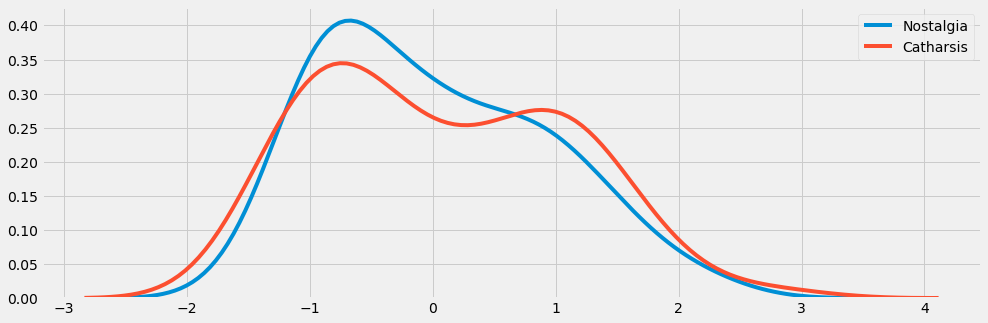

In [13]:
plt.figure(figsize = (15,5))

for i in np.arange(0,2,1):
    sns.kdeplot(dfCaNo["BPM"].loc[dfCaNo["Playlist"] == i], label = playlistNames[i])

plt.legend(loc = "upper right")

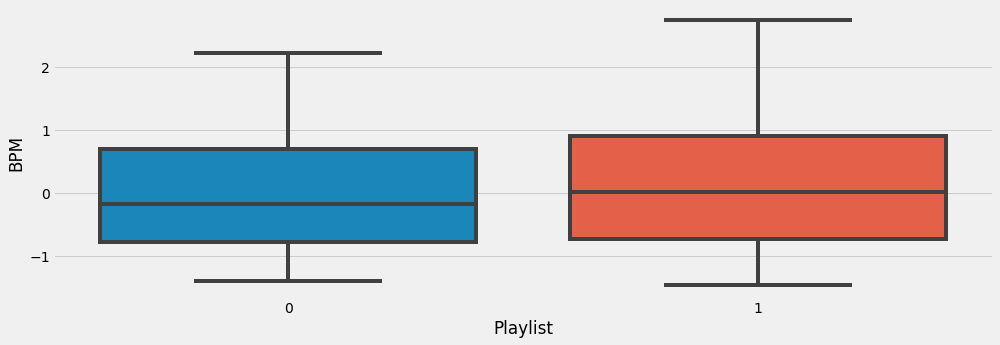

In [14]:
plt.figure(figsize = (15,5))

sns.boxplot(x = "Playlist", y = "BPM", data = dfCaNo)

## Energy

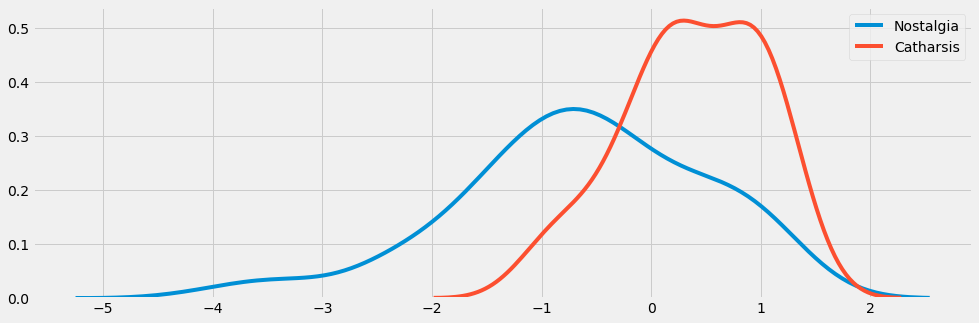

In [15]:
plt.figure(figsize = (15,5))

for i in np.arange(0,2,1):
    sns.kdeplot(dfCaNo["Energy"].loc[dfCaNo["Playlist"] == i], label = playlistNames[i])

plt.legend(loc = "upper right")

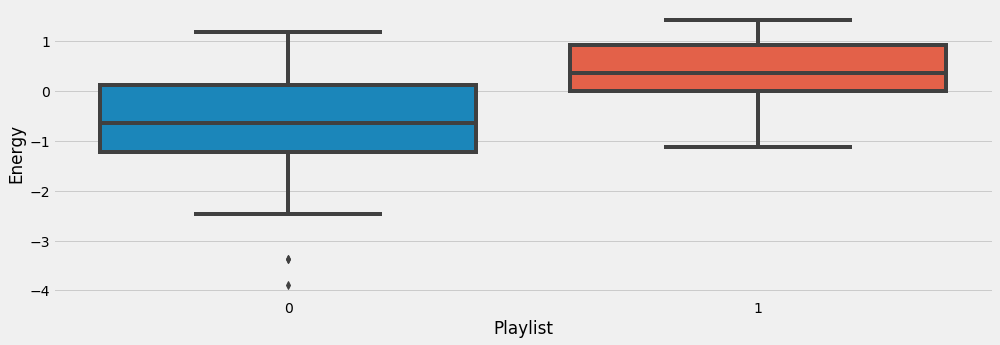

In [16]:
plt.figure(figsize = (15,5))

sns.boxplot(x = "Playlist", y = "Energy", data = dfCaNo)

## Dance

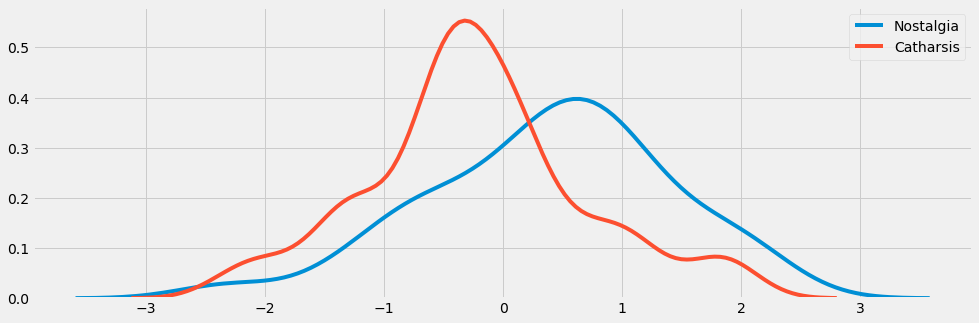

In [17]:
plt.figure(figsize = (15,5))

for i in np.arange(0,2,1):
    sns.kdeplot(dfCaNo["Dance"].loc[dfCaNo["Playlist"] == i], label = playlistNames[i])

plt.legend(loc = "upper right")

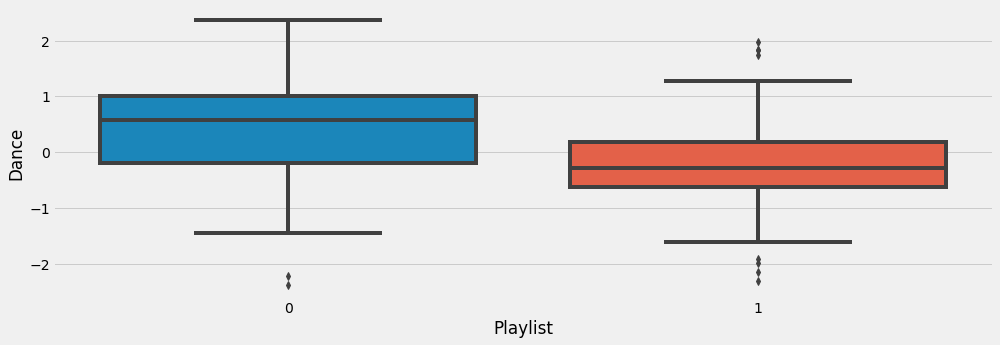

In [18]:
plt.figure(figsize = (15,5))

sns.boxplot(x = "Playlist", y = "Dance", data = dfCaNo)

## Loud

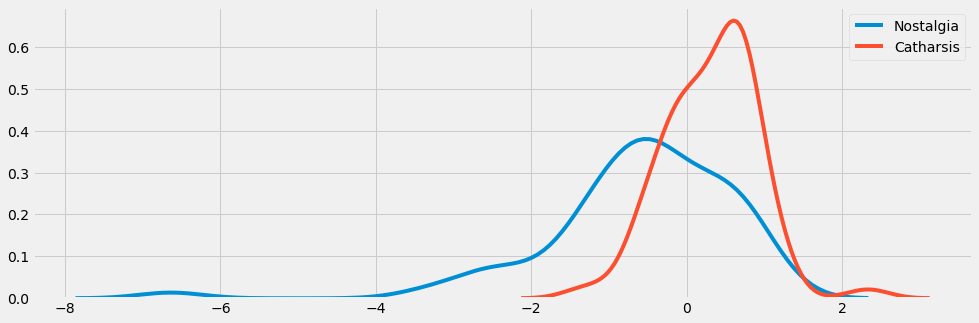

In [19]:
plt.figure(figsize = (15,5))

for i in np.arange(0,2,1):
    sns.kdeplot(dfCaNo["Loud"].loc[dfCaNo["Playlist"] == i], label = playlistNames[i])

plt.legend(loc = "upper right")

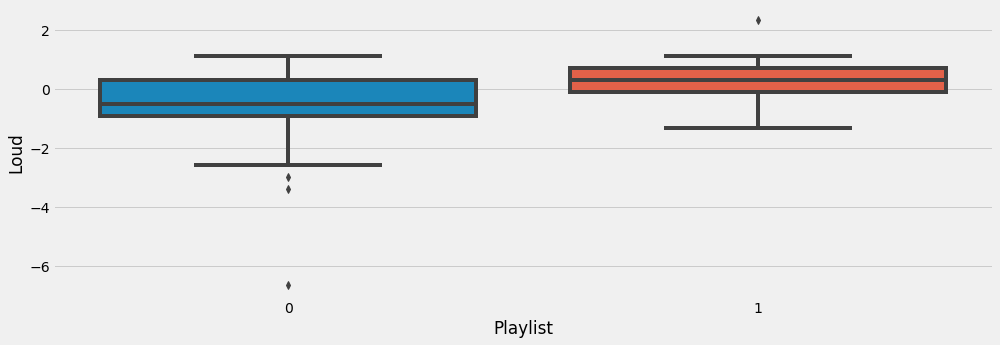

In [20]:
plt.figure(figsize = (15,5))

sns.boxplot(x = "Playlist", y = "Loud", data = dfCaNo)

## Valence

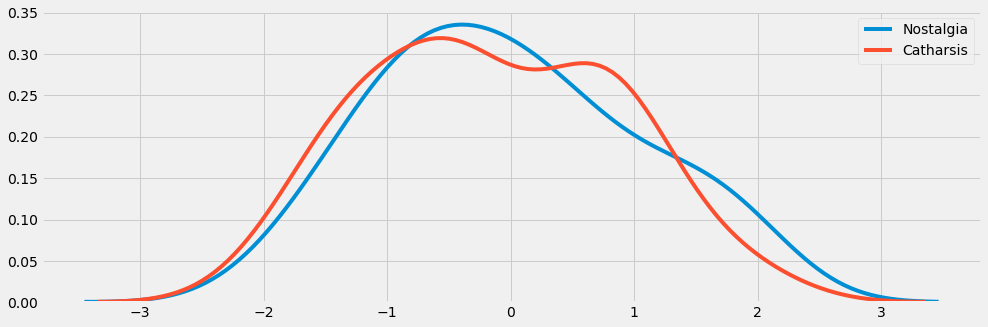

In [21]:
plt.figure(figsize = (15,5))

for i in np.arange(0,2,1):
    sns.kdeplot(dfCaNo["Valence"].loc[dfCaNo["Playlist"] == i], label = playlistNames[i])

plt.legend(loc = "upper right")

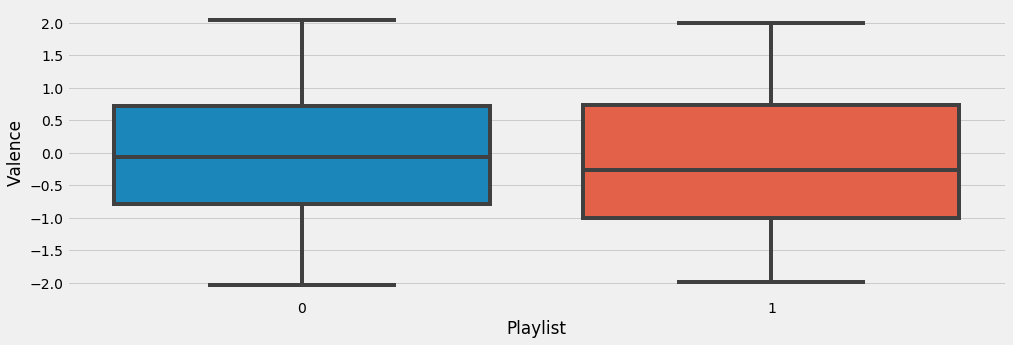

In [22]:
plt.figure(figsize = (15,5))

sns.boxplot(x = "Playlist", y = "Valence", data = dfCaNo)

## Length

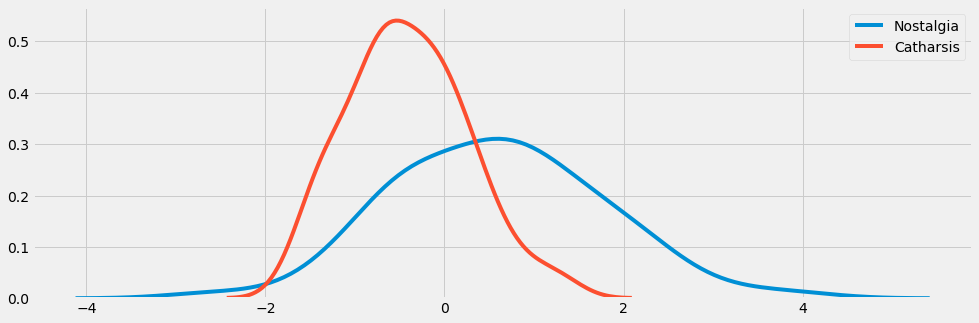

In [23]:
plt.figure(figsize = (15,5))

for i in np.arange(0,2,1):
    sns.kdeplot(dfCaNo["Length"].loc[dfCaNo["Playlist"] == i], label = playlistNames[i])

plt.legend(loc = "upper right")

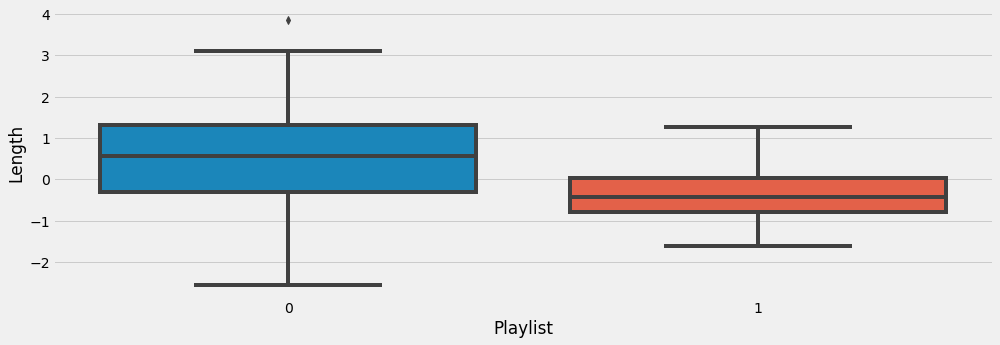

In [24]:
plt.figure(figsize = (15,5))

sns.boxplot(x = "Playlist", y = "Length", data = dfCaNo)

## Acoustic

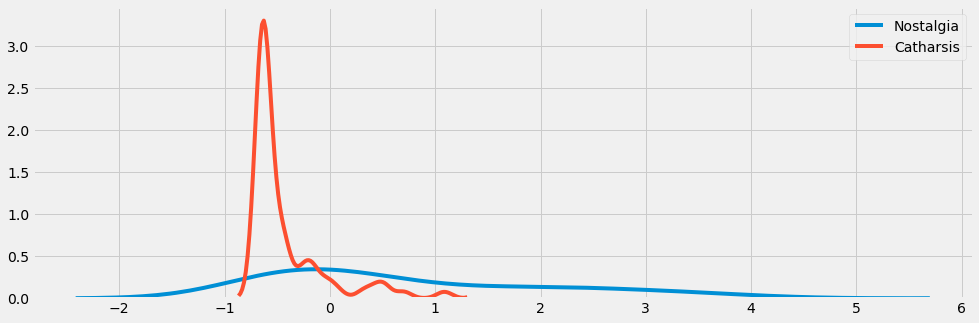

In [25]:
plt.figure(figsize = (15,5))

for i in np.arange(0,2,1):
    sns.kdeplot(dfCaNo["Acoustic"].loc[dfCaNo["Playlist"] == i], label = playlistNames[i])

plt.legend(loc = "upper right")

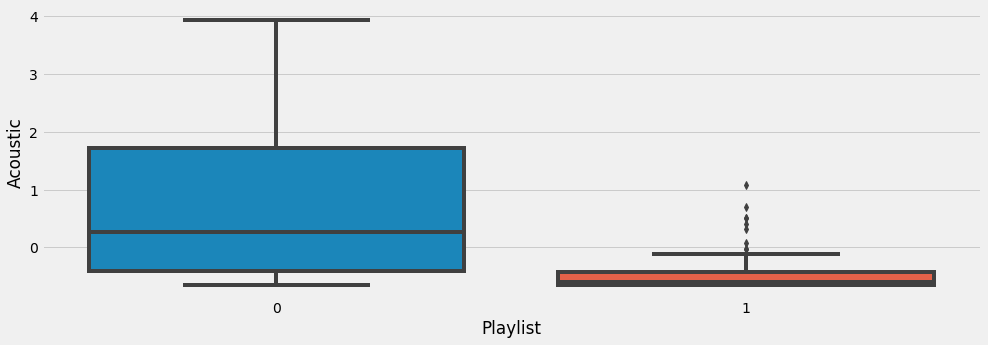

In [26]:
plt.figure(figsize = (15,5))

sns.boxplot(x = "Playlist", y = "Acoustic", data = dfCaNo)

## Popularity

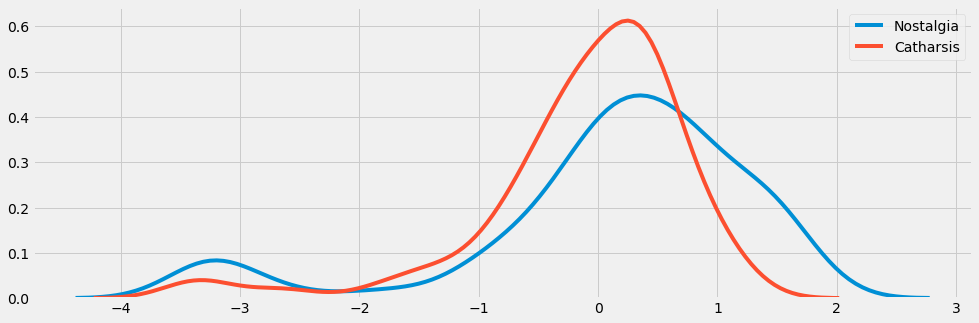

In [27]:
plt.figure(figsize = (15,5))

for i in np.arange(0,2,1):
    sns.kdeplot(dfCaNo["Popularity"].loc[dfCaNo["Playlist"] == i], label = playlistNames[i])

plt.legend(loc = "upper right")

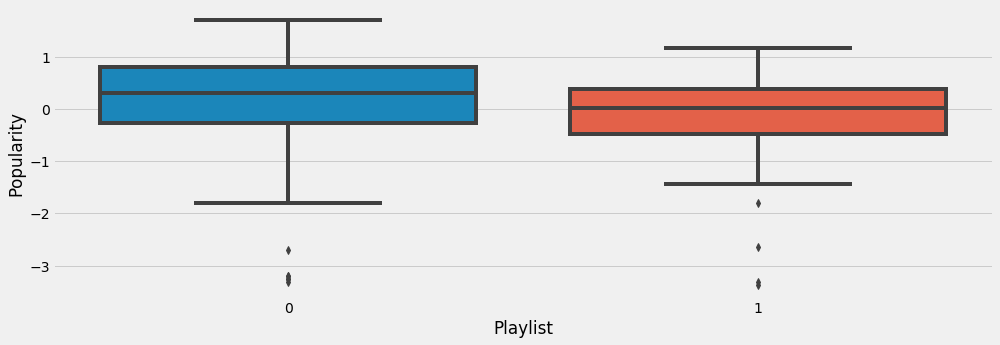

In [28]:
plt.figure(figsize = (15,5))

sns.boxplot(x = "Playlist", y = "Popularity", data = dfCaNo)

It appears that Valence, Popularity, and BPM are similar between the Nostalgia and Catharsis playlists. Removing these features may prove useful.

Recursive Feature Elimination may also be run to find which features should be removed, but as the number of features is small, removing features by hand should be faster.

In [29]:
cols = dfCaNo.columns[~dfCaNo.columns.isin(["Popularity", "Valence", "BPM"])]
dfCaNo = dfCaNo[cols]
dfCaNo.head()

,Energy,Dance,Loud,Length,Acoustic,Playlist
1,-1.414857,-0.043924,-0.928342,1.970664,0.749249,0
3,-1.532786,1.591255,-0.112906,0.464515,0.749249,0
6,0.648917,2.136315,-1.336060,1.125106,1.231438,0
7,-2.181401,1.980584,-0.520624,0.279549,0.122402,0
9,-2.476226,0.423270,-1.743778,0.570209,3.931701,0


# Models
The goal here is to predict which playlist each song is in. The problem is a binary classification problem. The models we will use are XGBoost, SVM, and Logistic Regression.

In [30]:
rf, x_train, x_test, y_train, y_test = RandFor(dfCaNo, "Playlist")

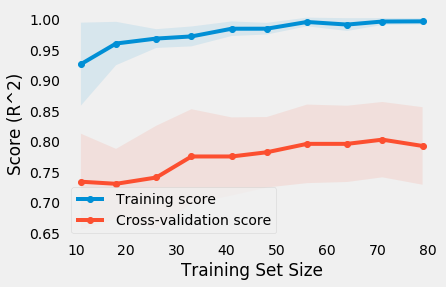

In [31]:
XCaNo = dfCaNo.drop(["Playlist"], axis = 1).values
yCaNo = dfCaNo["Playlist"]

LearningCurves(rf, XCaNo, yCaNo)

In [41]:
y_test_bin[:,0]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1])

In [40]:
y_score[:,0]

array([6.7331421e-01, 9.9802512e-01, 6.3481736e-01, 9.9815553e-01,
       9.7313702e-01, 9.9678749e-01, 5.3611398e-03, 1.2375951e-01,
       5.8205128e-03, 2.5557071e-01, 2.2418934e-01, 1.5456724e-01,
       9.7606188e-01, 6.7331421e-01, 4.9314737e-02, 9.8849392e-01,
       5.2700579e-02, 2.0335537e-01, 1.3810593e-01, 8.7355906e-01,
       9.6793932e-01, 9.7988474e-01, 9.7713786e-01, 9.9876177e-01,
       9.9714082e-01, 1.0169011e-01, 6.7091238e-01, 3.2884055e-01,
       2.6779056e-02, 3.0885488e-01, 9.9596715e-01, 9.7619909e-01,
       9.0634823e-04, 1.5456724e-01, 4.9429518e-01, 3.8397312e-01,
       9.2806077e-01, 3.6829591e-01, 9.8657352e-01, 3.0001986e-01,
       9.0486968e-01, 2.9926479e-02, 4.4157684e-02, 9.9140257e-01,
       9.5115221e-01, 9.9902117e-01, 1.3885295e-01, 1.2395382e-03,
       1.2368488e-01, 5.7238340e-04, 6.2113404e-02, 8.4886199e-01,
       9.8698336e-01, 6.2113404e-02, 3.0706525e-02, 9.9834377e-01,
       8.0968493e-01, 4.2914152e-03, 3.2146692e-02, 8.8872313e

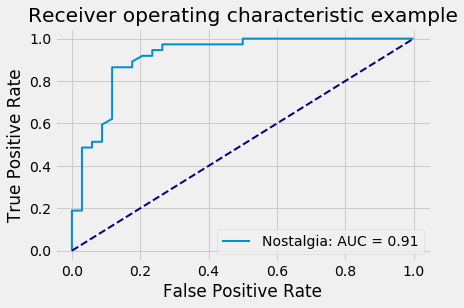

In [44]:
labels = ["Nostalgia", "Catharsis"]

y_new = label_binarize(yCaNo, classes=[0,1])

n_classes = y_new.shape[1]

x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(XCaNo, y_new, test_size=.5, random_state=0)

classifier = OneVsRestClassifier(rf)
y_score = classifier.fit(x_train_bin, y_train_bin).predict_proba(x_test_bin)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test_bin[:,0], y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, lw=lw, label=str(labels[0]) + ": AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()